# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [30]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

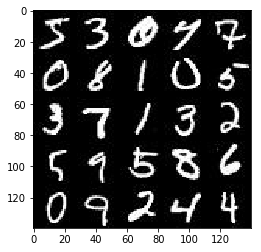

In [31]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

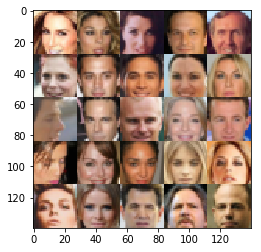

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [34]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [101]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3 
        x1 = tf.layers.conv2d(images, 16, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x16 now
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64 now
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 now
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [102]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 16, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x16 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [103]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [104]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    

    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
    with tf.control_dependencies(g_update_ops):    
        g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [105]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [106]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_num in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Generate noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_num+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 50 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 6.0838
Epoch 1/2... Discriminator Loss: 5.7097... Generator Loss: 8.5157
Epoch 1/2... Discriminator Loss: 2.2732... Generator Loss: 5.9414
Epoch 1/2... Discriminator Loss: 1.5346... Generator Loss: 5.2754
Epoch 1/2... Discriminator Loss: 1.7371... Generator Loss: 4.6451


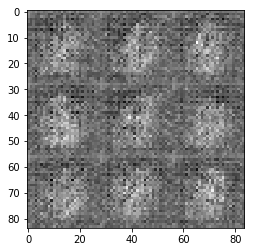

Epoch 1/2... Discriminator Loss: 1.5067... Generator Loss: 3.6341
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 3.3399
Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 3.5133
Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 3.5843
Epoch 1/2... Discriminator Loss: 0.9511... Generator Loss: 3.1208


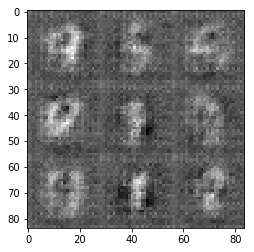

Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 3.2314
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 2.9925
Epoch 1/2... Discriminator Loss: 1.1386... Generator Loss: 2.9306
Epoch 1/2... Discriminator Loss: 0.9070... Generator Loss: 2.6558
Epoch 1/2... Discriminator Loss: 0.8718... Generator Loss: 2.8328


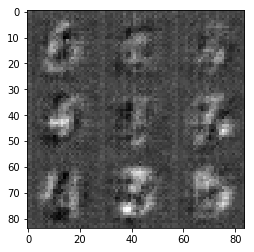

Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 3.0072
Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 2.7100
Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 2.8141
Epoch 1/2... Discriminator Loss: 0.7857... Generator Loss: 3.2688
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 2.8360


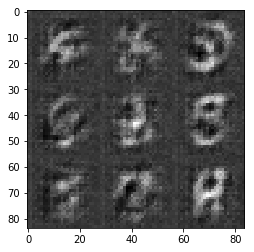

Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 3.3392
Epoch 1/2... Discriminator Loss: 0.6833... Generator Loss: 2.9880
Epoch 1/2... Discriminator Loss: 0.5280... Generator Loss: 2.1817
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 3.0349
Epoch 1/2... Discriminator Loss: 0.7132... Generator Loss: 3.0366


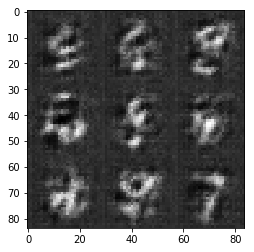

Epoch 1/2... Discriminator Loss: 1.8750... Generator Loss: 3.2976
Epoch 1/2... Discriminator Loss: 0.4255... Generator Loss: 1.7347
Epoch 1/2... Discriminator Loss: 0.5750... Generator Loss: 2.4900
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 3.0491
Epoch 1/2... Discriminator Loss: 0.5125... Generator Loss: 2.6891


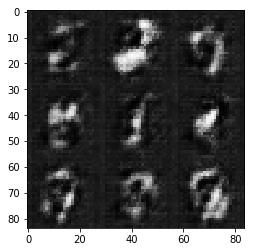

Epoch 1/2... Discriminator Loss: 0.3733... Generator Loss: 1.7863
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 4.0152
Epoch 1/2... Discriminator Loss: 0.6979... Generator Loss: 1.9384
Epoch 1/2... Discriminator Loss: 0.6018... Generator Loss: 2.0694
Epoch 1/2... Discriminator Loss: 0.4827... Generator Loss: 1.9238


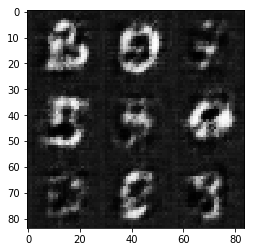

Epoch 1/2... Discriminator Loss: 0.6272... Generator Loss: 2.7315
Epoch 1/2... Discriminator Loss: 0.5559... Generator Loss: 2.5587
Epoch 1/2... Discriminator Loss: 0.5119... Generator Loss: 2.2536
Epoch 1/2... Discriminator Loss: 0.6106... Generator Loss: 2.6349
Epoch 1/2... Discriminator Loss: 4.5154... Generator Loss: 3.7287


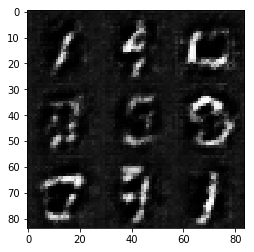

Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 2.1636
Epoch 1/2... Discriminator Loss: 0.5709... Generator Loss: 1.1217
Epoch 1/2... Discriminator Loss: 0.5177... Generator Loss: 1.3210
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 2.6132
Epoch 1/2... Discriminator Loss: 0.5683... Generator Loss: 1.6884


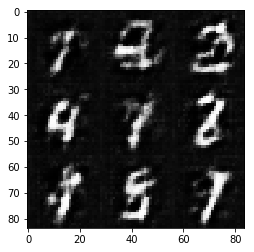

Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 2.9390
Epoch 2/2... Discriminator Loss: 0.5835... Generator Loss: 1.3439
Epoch 2/2... Discriminator Loss: 0.5991... Generator Loss: 1.8541
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 2.1462
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 1.9424
Epoch 2/2... Discriminator Loss: 0.6510... Generator Loss: 1.0067


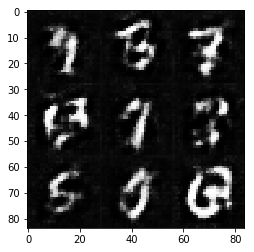

Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 0.6588
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.3599
Epoch 2/2... Discriminator Loss: 0.7575... Generator Loss: 0.7996
Epoch 2/2... Discriminator Loss: 0.7260... Generator Loss: 2.2012
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 2.4088


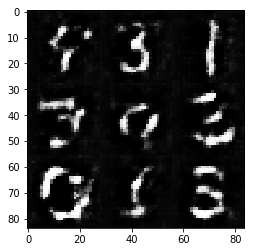

Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 1.6193
Epoch 2/2... Discriminator Loss: 0.5992... Generator Loss: 1.2114
Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 0.5030
Epoch 2/2... Discriminator Loss: 2.3472... Generator Loss: 0.1390
Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 0.7465


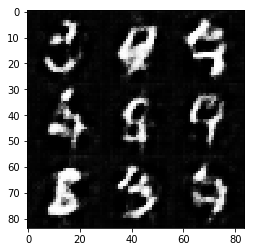

Epoch 2/2... Discriminator Loss: 0.7804... Generator Loss: 0.8717
Epoch 2/2... Discriminator Loss: 0.9394... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.3618


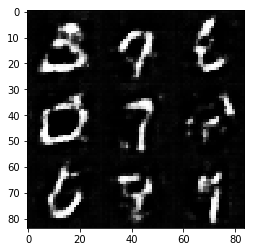

Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 0.5003
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 0.5000
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.0977


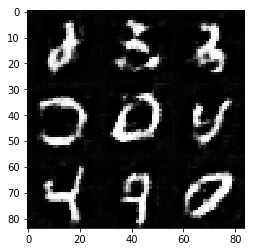

Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 2.1342
Epoch 2/2... Discriminator Loss: 0.5818... Generator Loss: 1.3129
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 0.9023
Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 0.4361
Epoch 2/2... Discriminator Loss: 1.6303... Generator Loss: 0.2804


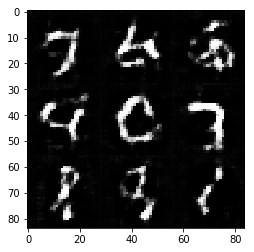

Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 0.4466
Epoch 2/2... Discriminator Loss: 0.7720... Generator Loss: 0.8558
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 0.6975... Generator Loss: 1.0643


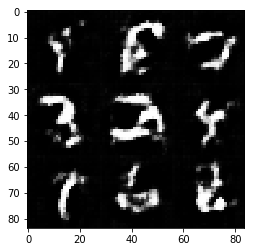

Epoch 2/2... Discriminator Loss: 1.8886... Generator Loss: 3.1107
Epoch 2/2... Discriminator Loss: 0.6325... Generator Loss: 1.2955
Epoch 2/2... Discriminator Loss: 0.7046... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 1.4286... Generator Loss: 0.3464
Epoch 2/2... Discriminator Loss: 1.0597... Generator Loss: 0.5507


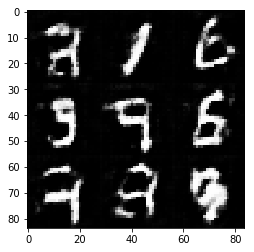

Epoch 2/2... Discriminator Loss: 0.7091... Generator Loss: 1.2537
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 1.0482
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 1.7089... Generator Loss: 0.2657
Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 0.7533


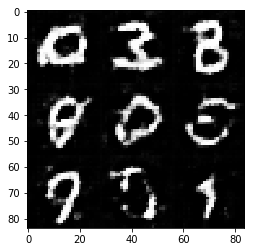

Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 0.5345


In [113]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.001

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2518... Generator Loss: 1.9959
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 0.2480... Generator Loss: 5.8375
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 5.9742
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 6.1048


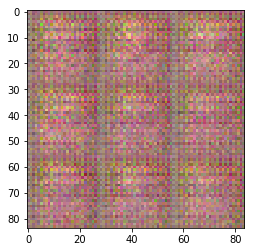

Epoch 1/1... Discriminator Loss: 0.2317... Generator Loss: 7.1554
Epoch 1/1... Discriminator Loss: 2.2320... Generator Loss: 0.1465
Epoch 1/1... Discriminator Loss: 1.6305... Generator Loss: 0.2538
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 0.6078


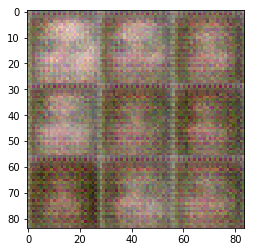

Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.5381


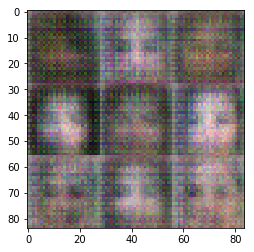

Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.4445


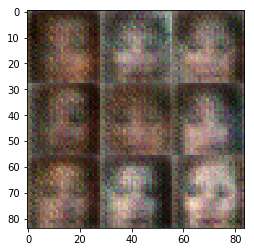

Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.3664
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 0.6910


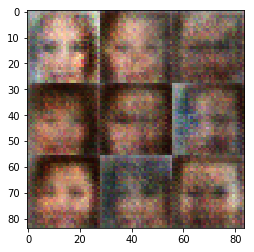

Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.2901
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.4326
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.3371
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.5566


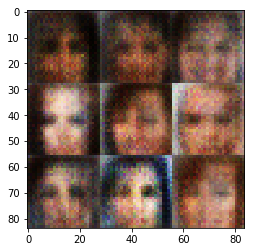

Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.3270
Epoch 1/1... Discriminator Loss: 1.7591... Generator Loss: 0.2426
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 0.6134


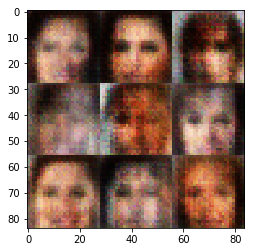

Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.4464
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.3602
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.3886


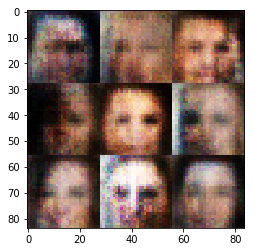

Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 0.6608


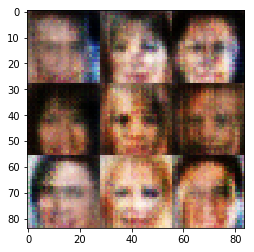

Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 0.2774
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 1.2195
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 0.9782


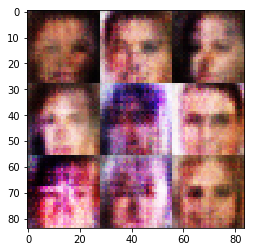

Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.4380
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.3798
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.4480


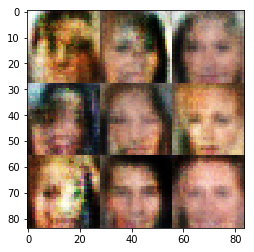

Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.3321
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.5453


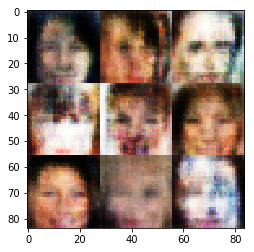

Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.3817


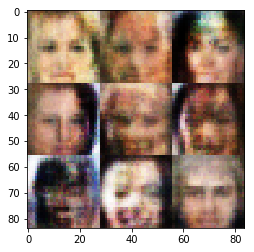

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.3093


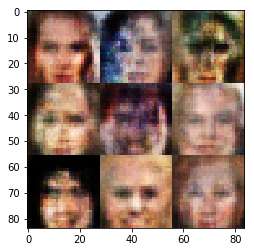

Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.4037
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 0.8702


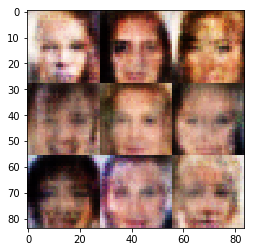

Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.3885
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.5073


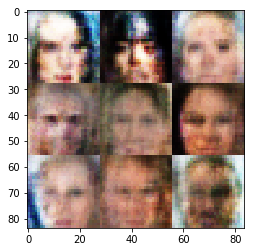

Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.3639
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 0.8275


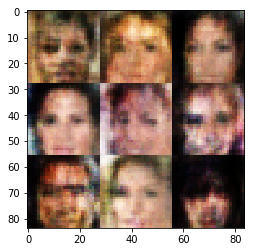

Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.3075
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.6136


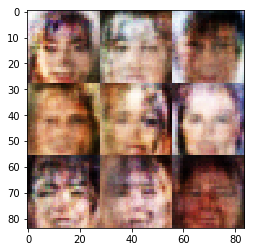

Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.2976
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.3838


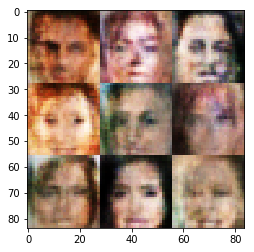

Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.4331


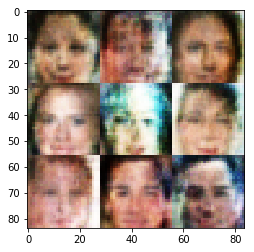

Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.3394
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.3715
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.4470


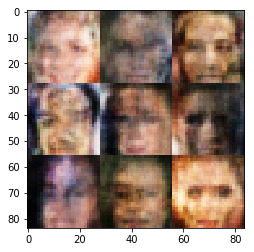

Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.4400
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.5524


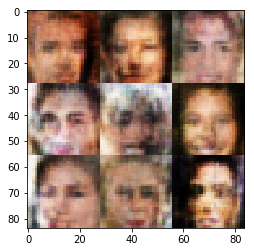

Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 1.9309... Generator Loss: 1.9722
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 1.2791
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8724


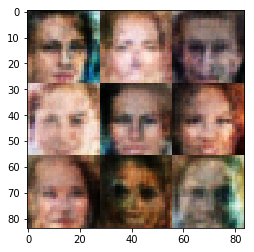

Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.2904


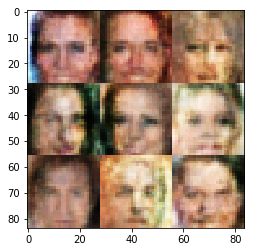

Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.3393
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 1.5031
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.1638


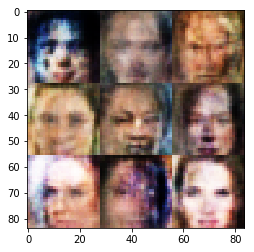

Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 2.7363... Generator Loss: 2.3966
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.0745


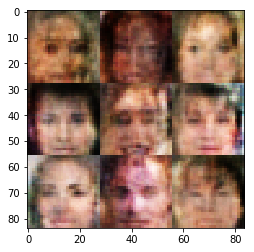

Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.3633
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.3731


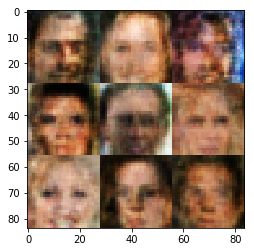

Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 1.0587


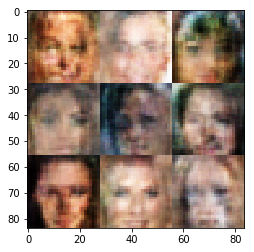

Epoch 1/1... Discriminator Loss: 2.3865... Generator Loss: 2.1145
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.0251


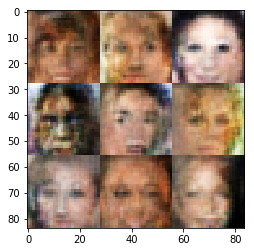

Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.4010
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.3854


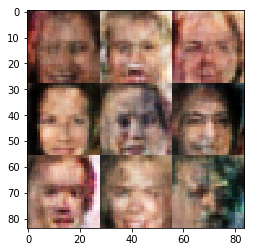

Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.7360
Epoch 1/1... Discriminator Loss: 1.7967... Generator Loss: 1.4475


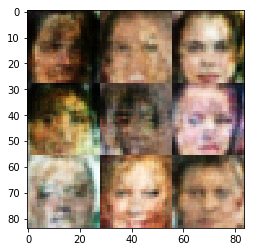

Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.1904


In [114]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.001


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.